In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
import umap
import logomaker

In [2]:
RANDOM_STATE = 42

# -----------------------------
# 1. Load and clean data
# -----------------------------

df = pd.read_csv("../data/TCR-A3_CDR3b-t4x_MAGE-A3_specificity.csv")

# Keep only confident labels
df = df[df["specificity"].isin([0, 1])].reset_index(drop=True)

# Check fixed-length CDR3β
cdr3_lengths = df["cdr3"].str.len().unique()
if len(cdr3_lengths) != 1:
    raise ValueError("All CDR3β sequences must have the same length")

cdr3_len = cdr3_lengths[0]
print(f"CDR3β length: {cdr3_len}")


CDR3β length: 13


In [86]:
# -----------------------------
# 2. Position-wise encoding
# -----------------------------

def explode_cdr3(df, column="cdr3", prefix="pos"):
    return pd.DataFrame(
        df[column].apply(list).tolist(),
        columns=[f"{prefix}_{i}" for i in range(df[column].str.len().iloc[0])]
    )

X_df = explode_cdr3(df)
y = df["specificity"].values

display(X_df, y)

,pos_0,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8,pos_9,pos_10,pos_11,pos_12
0,C,A,A,A,A,S,M,A,D,E,Q,Y,F
1,C,A,A,A,C,Q,M,A,D,E,Q,Y,F
2,C,A,A,A,G,G,M,A,D,E,Q,Y,F
3,C,A,A,A,L,S,M,A,D,E,Q,Y,F
4,C,A,A,A,N,N,M,A,D,E,Q,Y,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25570,C,Y,W,L,V,N,M,A,D,E,Q,Y,F
25571,C,Y,Y,G,I,N,M,A,D,E,Q,Y,F
25572,C,Y,Y,G,L,N,M,A,D,E,Q,Y,F
25573,C,Y,Y,H,V,N,M,A,D,E,Q,Y,F


array([0, 0, 0, ..., 0, 0, 1])

In [87]:
np.unique(y, return_counts=True)

(array([0, 1]), array([24154,  1421]))

In [88]:
# -----------------------------
# 3. Train/test split
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

In [89]:
# One-hot encoder
ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=True
)

In [90]:
models = {
    "Logistic Regression": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(
            max_iter=1000,
            n_jobs=-1
        ))
    ]),
    "SVM (RBF)": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", SVC(
            kernel="rbf",
            probability=True
        ))
    ]),
    "Random Forest": Pipeline([
        ("ohe", ohe),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
}

In [91]:
# -----------------------------
# 5. Train + evaluate
# -----------------------------

results = []
roc_data = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUROC": roc_auc_score(y_test, y_prob)
    }

    results.append(metrics)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, metrics["AUROC"])

results_df = pd.DataFrame(results)

Training Logistic Regression...


KeyboardInterrupt: 

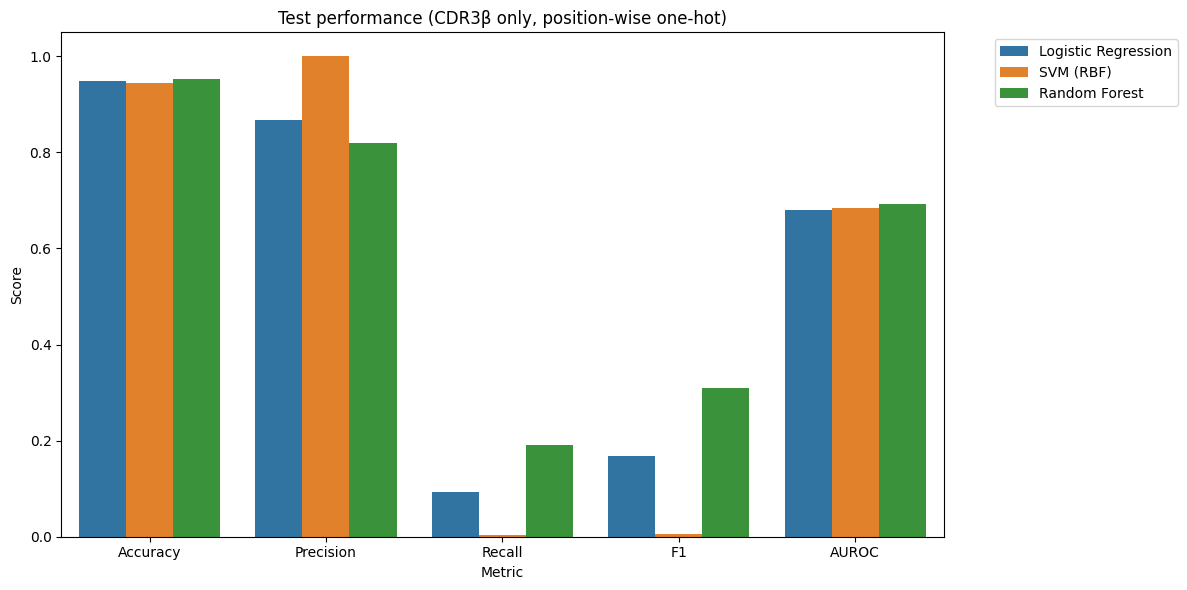

In [9]:
# -----------------------------
# 6. Metric bar plots
# -----------------------------

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "AUROC"]

results_long = results_df.melt(
    id_vars="Model",
    value_vars=metrics_to_plot,
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_long,
    x="Metric",
    y="Score",
    hue="Model"
)
plt.ylim(0, 1.05)
plt.title("Test performance (CDR3β only, position-wise one-hot)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

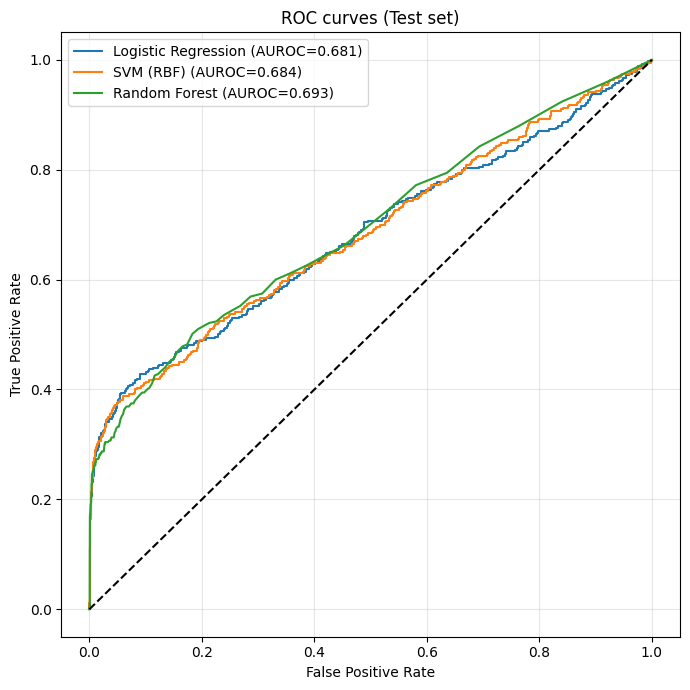

In [10]:
# -----------------------------
# 7. ROC curves
# -----------------------------

plt.figure(figsize=(7, 7))

for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUROC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (Test set)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# -----------------------------
# 8. Print summary table
# -----------------------------

print("\nTest-set performance summary:")
print(results_df.round(3))



Test-set performance summary:
                 Model  Accuracy  Precision  Recall     F1  AUROC
0  Logistic Regression     0.949      0.868   0.093  0.168  0.681
1            SVM (RBF)     0.944      1.000   0.003  0.006  0.684
2        Random Forest     0.953      0.819   0.192  0.311  0.693


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

RANDOM_STATE = 42

In [93]:
# -----------------------------
# 1. Load and clean data
# -----------------------------
df = pd.read_csv("../data/TCR-A3_CDR3b-t4x_MAGE-A3_specificity.csv")
df = df[df["specificity"].isin([0, 1])].reset_index(drop=True)

cdr3_lengths = df["cdr3"].str.len().unique()
if len(cdr3_lengths) != 1:
    raise ValueError("All CDR3β sequences must have the same length")
cdr3_len = cdr3_lengths[0]
print(f"CDR3β length: {cdr3_len}")

CDR3β length: 13


In [94]:
# -----------------------------
# 2. Position-wise one-hot encoding
# -----------------------------
def explode_cdr3(df, column="cdr3", prefix="pos"):
    return pd.DataFrame(df[column].apply(list).tolist(),
                        columns=[f"{prefix}_{i}" for i in range(df[column].str.len().iloc[0])])

X_df = explode_cdr3(df)
y = df["specificity"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)


In [17]:
# -----------------------------
# 3. Define Laplace kernel
# -----------------------------
def laplace_kernel(X, Y, sigma=1.0):
    X = X.toarray() if hasattr(X, "toarray") else X
    Y = Y.toarray() if hasattr(Y, "toarray") else Y
    pairwise_l1 = np.sum(np.abs(X[:, None, :] - Y[None, :, :]), axis=2)
    return np.exp(-pairwise_l1 / sigma)

In [18]:
# -----------------------------
# 4. SVM kernel comparison
# -----------------------------
svm_models = {
    "SVM Linear": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", SVC(kernel="linear", probability=True))
    ]),
    "SVM RBF": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", SVC(kernel="rbf", probability=True))
    ]),
    "SVM Laplace": Pipeline([
        ("ohe", ohe),
        ("clf", SVC(kernel=laplace_kernel, probability=True))
    ])
}

svm_results = []
svm_roc = {}

for name, model in svm_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUROC": roc_auc_score(y_test, y_prob)
    }
    svm_results.append(metrics)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    svm_roc[name] = (fpr, tpr, metrics["AUROC"])

svm_df = pd.DataFrame(svm_results)
print("\nSVM kernel comparison:")
print(svm_df.round(3))

# Pick the best SVM (highest AUROC)
best_svm_name = svm_df.sort_values("AUROC", ascending=False)["Model"].iloc[0]
print(f"\nBest SVM kernel: {best_svm_name}")

Training SVM Linear...


/cluster/project/reddy/marluca/NGS_pipeline/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training SVM RBF...
Training SVM Laplace...


In [1]:
# -----------------------------
# 5. Compare best SVM vs LR & RF
# -----------------------------
comparison_models = {
    best_svm_name: svm_models[best_svm_name],
    "Logistic Regression": Pipeline([
        ("ohe", ohe),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]),
    "Random Forest": Pipeline([
        ("ohe", ohe),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
    ])
}

results = []
roc_data = {}

for name, model in comparison_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUROC": roc_auc_score(y_test, y_prob)
    }
    results.append(metrics)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, metrics["AUROC"])

results_df = pd.DataFrame(results)

NameError: name 'best_svm_name' is not defined

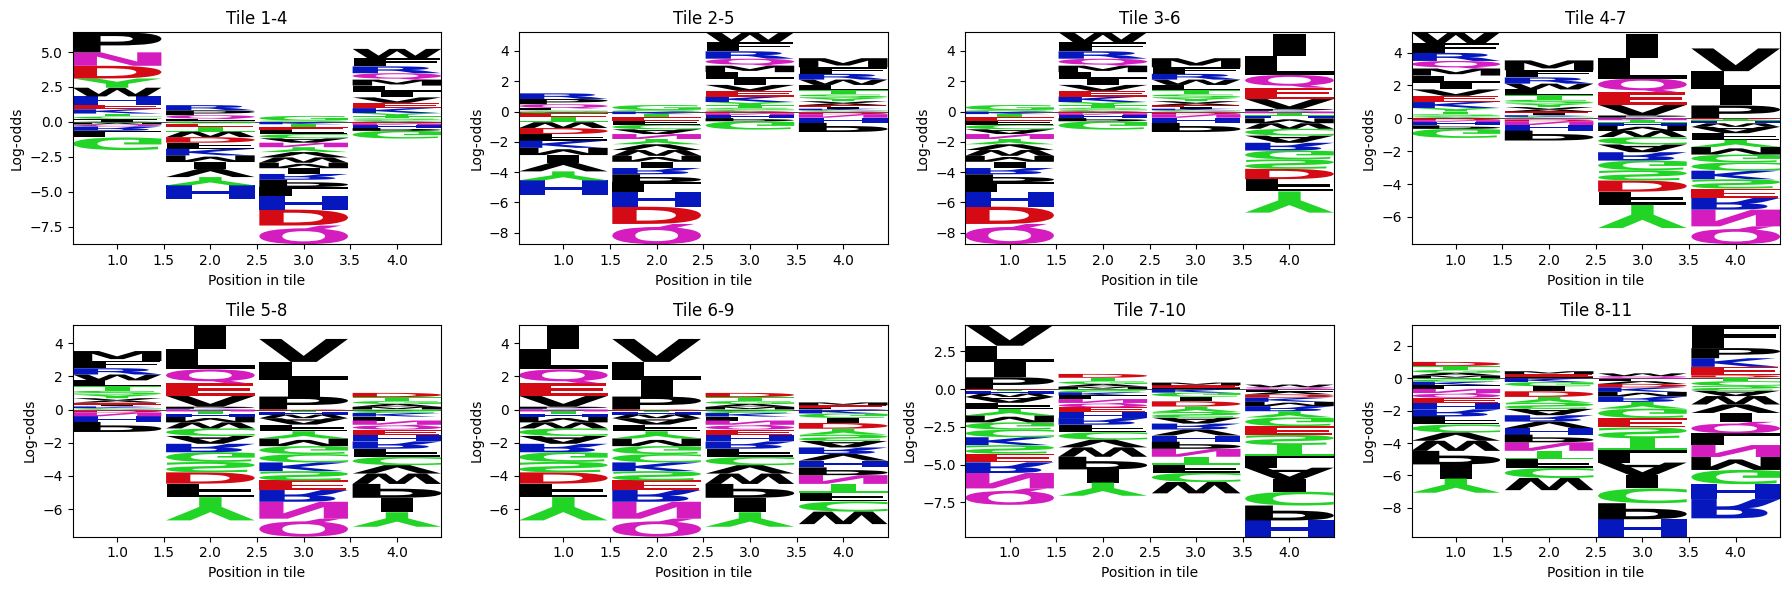

In [95]:
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")

# tiles defined in STRING coordinates (0-based slicing!)
# skip leading C -> positions 1..11
TILES = [(1,4), (2,5), (3,6), (4,7), (5,8), (6,9), (7,10), (8,11)]

fig, axes = plt.subplots(2, 4, figsize=(18, 6))
axes = axes.flatten()

for t_idx, (start, end) in enumerate(TILES):

    # positions in string (Python slicing)
    positions = list(range(start, end + 1))

    # initialize count matrices
    spec_counts = pd.DataFrame(
        1.0,  # pseudocount
        index=positions,
        columns=AA_LIST
    )
    unspec_counts = spec_counts.copy()

    # count residues
    for pos in positions:
        for aa in AA_LIST:
            spec_counts.loc[pos, aa] += (
                (df['cdr3'].str[pos] == aa) & (df['specificity'] == 1)
            ).sum()
            unspec_counts.loc[pos, aa] += (
                (df['cdr3'].str[pos] == aa) & (df['specificity'] == 0)
            ).sum()

    # normalize per position
    spec_freq = spec_counts.div(spec_counts.sum(axis=1), axis=0)
    unspec_freq = unspec_counts.div(unspec_counts.sum(axis=1), axis=0)

    # log-odds
    log_odds = np.log(spec_freq / unspec_freq)

    # make absolutely sure everything is finite
    log_odds = log_odds.replace([np.inf, -np.inf], 0.0).fillna(0.0)

    # rename positions to 1..4 for the tile
    log_odds.index = range(1, len(positions) + 1)

    # 🔑 THIS IS THE IMPORTANT PART:
    # index = positions, columns = amino acids
    logomaker.Logo(
        log_odds,
        ax=axes[t_idx],
        shade_below=0,
        fade_below=0.0
    )

    axes[t_idx].set_title(f"Tile {start}-{end}")
    axes[t_idx].set_xlabel("Position in tile")
    axes[t_idx].set_ylabel("Log-odds")

plt.tight_layout()
plt.show()

In [96]:
pos_df = df[df['specificity'] == 1].reset_index(drop=True)

In [97]:
import numpy as np
from sklearn.metrics import mutual_info_score

SEQ_LEN = len(pos_df['cdr3'].iloc[0])
mi_matrix = np.zeros((SEQ_LEN, SEQ_LEN))

for i in range(SEQ_LEN):
    for j in range(SEQ_LEN):
        mi_matrix[i,j] = mutual_info_score(pos_df['cdr3'].str[i], pos_df['cdr3'].str[j])


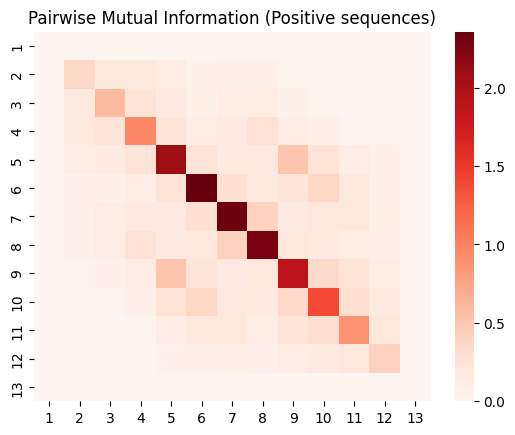

In [98]:
import seaborn as sns
sns.heatmap(mi_matrix, cmap='Reds', xticklabels=range(1,SEQ_LEN+1), yticklabels=range(1,SEQ_LEN+1))
plt.title("Pairwise Mutual Information (Positive sequences)")
plt.show()

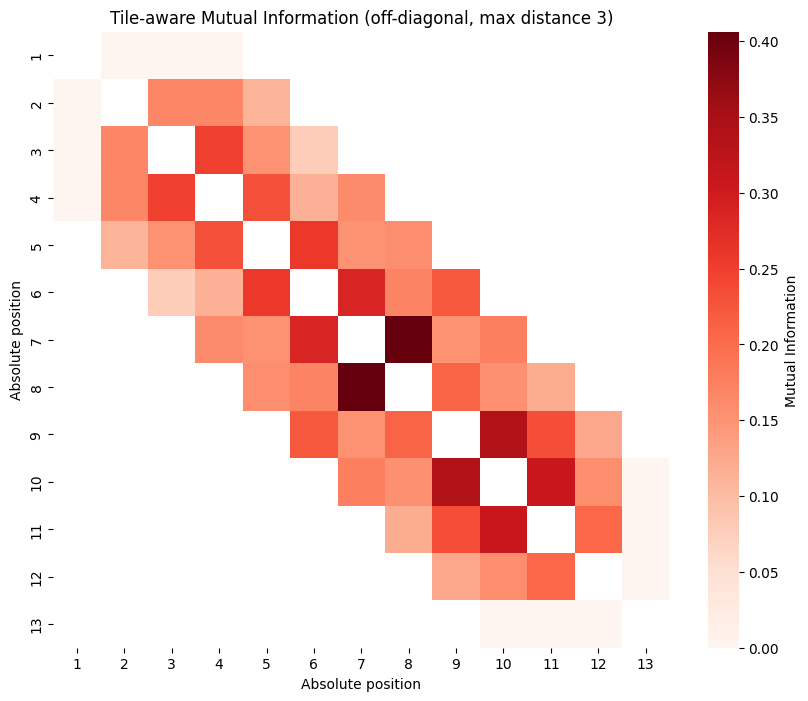

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score

# -----------------------------
# Parameters
# -----------------------------
SEQ_COL = 'cdr3'
SPEC_COL = 'specificity'

# Only positive sequences
pos_df = df[df[SPEC_COL] == 1].reset_index(drop=True)
SEQ_LEN = pos_df[SEQ_COL].str.len().iloc[0]  # should be 13

# Maximum distance for co-mutation (tile width)
MAX_TILE_DISTANCE = 3  # positions within 4-aa tiles: abs(i-j) <= 3

# Initialize full MI matrix
full_mi = np.full((SEQ_LEN, SEQ_LEN), np.nan)  # start with NaN

# -----------------------------
# Compute MI for all pairs within tile distance
# -----------------------------
for i in range(SEQ_LEN):
    for j in range(i+1, min(i + MAX_TILE_DISTANCE + 1, SEQ_LEN)):
        col_i = pos_df[SEQ_COL].str[i]
        col_j = pos_df[SEQ_COL].str[j]
        mi_val = mutual_info_score(col_i, col_j)
        full_mi[i, j] = mi_val
        full_mi[j, i] = mi_val  # symmetric

# -----------------------------
# Mask diagonal (self-MI) and positions too far apart
# -----------------------------
mask = np.eye(SEQ_LEN, dtype=bool)  # mask diagonal
# diagonal already masked; positions beyond MAX_TILE_DISTANCE are NaN → automatically ignored

# -----------------------------
# Plot heatmap
# -----------------------------
plt.figure(figsize=(10,8))
sns.heatmap(
    full_mi, 
    mask=mask, 
    cmap='Reds', 
    annot=False, 
    square=True, 
    cbar_kws={'label': 'Mutual Information'},
    xticklabels=range(1, SEQ_LEN+1),
    yticklabels=range(1, SEQ_LEN+1)
)
plt.title(f"Tile-aware Mutual Information (off-diagonal, max distance {MAX_TILE_DISTANCE})")
plt.xlabel("Absolute position")
plt.ylabel("Absolute position")
plt.show()

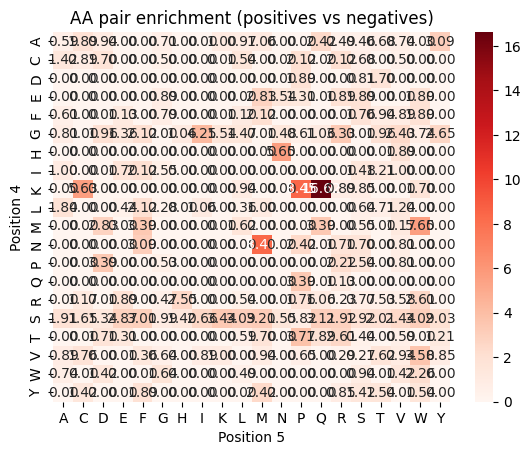

In [100]:
from collections import Counter
import pandas as pd

# Positive and negative sequences
pos_seqs = df[df['specificity']==1]['cdr3']
neg_seqs = df[df['specificity']==0]['cdr3']

# Define positions (absolute)
i, j = 3, 4  # example

# Count AA pairs in positive sequences
pos_pairs = [(seq[i], seq[j]) for seq in pos_seqs]
neg_pairs = [(seq[i], seq[j]) for seq in neg_seqs]

pos_counts = Counter(pos_pairs)
neg_counts = Counter(neg_pairs)

# Compute enrichment
enrichment = {}
for pair in pos_counts:
    pos_freq = pos_counts[pair] / len(pos_seqs)
    neg_freq = neg_counts.get(pair, 0) / len(neg_seqs)
    enrichment[pair] = (pos_freq + 1e-6) / (neg_freq + 1e-6)  # pseudocount

# Convert to DataFrame for heatmap
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")
enrich_matrix = pd.DataFrame(0, index=AA_LIST, columns=AA_LIST, dtype=float)
for (aa1, aa2), val in enrichment.items():
    enrich_matrix.at[aa1, aa2] = val

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(enrich_matrix, cmap='Reds', annot=True, fmt=".2f")
plt.xlabel(f"Position {j+1}")
plt.ylabel(f"Position {i+1}")
plt.title("AA pair enrichment (positives vs negatives)")
plt.show()

In [101]:
#Enriched pairwise motifs

import pandas as pd
from collections import Counter
import itertools

# -----------------------------
# positive sequences only
# -----------------------------
df_pos = df[df["specificity"] == 1].copy()

# remove leading C
df_pos["cdr3_var"] = df_pos["cdr3"].str[1:]

SEQ_LEN = len(df_pos["cdr3_var"].iloc[0])

# tiles defined on VARIABLE region
TILES = [(0,3), (1,4), (2,5), (3,6),
         (4,7), (5,8), (6,9), (7,10)]

# -----------------------------
# extract motifs WITH positions
# -----------------------------
def extract_positioned_motifs(seq, positions):
    motifs = []
    for i, j in itertools.combinations(positions, 2):
        gap = j - i - 1
        if gap <= 2:
            motifs.append({
                "pos1": i + 2,  # +2 = absolute CDR3 index
                "pos2": j + 2,
                "aa1": seq[i],
                "aa2": seq[j],
                "gap": gap,
                "motif": f"{seq[i]}{'*'*gap}{seq[j]}"
            })
    return motifs

# -----------------------------
# analyze per tile
# -----------------------------
tile_tables = {}

for start, end in TILES:
    rows = []

    positions = list(range(start, end + 1))
    for seq in df_pos["cdr3_var"]:
        rows.extend(extract_positioned_motifs(seq, positions))

    tile_name = f"Tile_{start+2}_{end+2}"
    df_motifs = pd.DataFrame(rows)

    summary = (
        df_motifs
        .groupby(["pos1", "pos2", "aa1", "aa2", "gap", "motif"])
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
    )

    tile_tables[tile_name] = summary

# -----------------------------
# show results
# -----------------------------
for tile, table in tile_tables.items():
    print(f"\n=== {tile} ===")
    print(table.head(15))


=== Tile_2_5 ===
     pos1  pos2 aa1 aa2  gap motif  count
14      2     3   A   S    0    AS   1262
95      2     4   A   S    1   A*S   1156
356     3     4   S   S    0    SS   1148
179     2     5   A   P    2  A**P    698
474     3     5   S   P    1   S*P    693
635     4     5   S   P    0    SP    688
176     2     5   A   L    2  A**L     81
471     3     5   S   L    1   S*L     78
181     2     5   A   R    2  A**R     72
184     2     5   A   V    2  A**V     70
476     3     5   S   R    1   S*R     69
632     4     5   S   L    0    SL     65
479     3     5   S   V    1   S*V     59
637     4     5   S   R    0    SR     54
182     2     5   A   S    2  A**S     54

=== Tile_3_6 ===
     pos1  pos2 aa1 aa2  gap motif  count
99      3     4   S   S    0    SS   1148
217     3     5   S   P    1   S*P    693
469     4     5   S   P    0    SP    688
321     3     6   S   N    2  S**N    485
616     4     6   S   N    1   S*N    465
821     5     6   P   N    0    PN    44

In [116]:
## conditional motif plots

AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")

# Remove leading C and trailing F
df["cdr3_var"] = df["cdr3"].str[1:12]  
SEQ_LEN = len(df["cdr3_var"].iloc[0]) 
df_pos = df[df["specificity"] == 1]

In [117]:
# --- Top enriched AA per position (anchor residues) ---
top_anchor = {}
for pos in range(SEQ_LEN):
    scores = {}
    for aa in AA_LIST:
        pos_pos = ((df["cdr3_var"].str[pos] == aa) & (df["specificity"] == 1)).sum()
        pos_neg = ((df["cdr3_var"].str[pos] == aa) & (df["specificity"] == 0)).sum()
        # keep original log-odds for anchor selection (small counts OK)
        scores[aa] = np.log((pos_pos + 1) / (pos_neg + 1))
    top_anchor[pos] = max(scores, key=scores.get)


In [118]:
# --- Function: tile matrix with raw frequencies and coverage mask ---
def tile_matrix_top_cooccurring(df_pos, anchor_pos, anchor_aa, min_count=3):
    start = max(0, anchor_pos - 3)
    end = min(SEQ_LEN - 1, anchor_pos + 3)
    positions = list(range(start, end + 1))

    subset = df_pos[df_pos["cdr3_var"].str[anchor_pos] == anchor_aa]

    counts = pd.DataFrame(0.0, index=positions, columns=AA_LIST)
    for pos in positions:
        for aa in AA_LIST:
            counts.loc[pos, aa] = (subset["cdr3_var"].str[pos] == aa).sum()

    # Compute frequencies only for positions with enough coverage
    filtered = pd.DataFrame(0.0, index=positions, columns=AA_LIST)
    coverage = counts.sum(axis=1)
    for pos in positions:
        if coverage[pos] < min_count:
            continue  # skip positions with too few sequences
        top_aa_pos = counts.loc[pos].idxmax()
        filtered.loc[pos, top_aa_pos] = counts.loc[pos, top_aa_pos] / coverage[pos]

    # Absolute positions (1-indexed)
    filtered.index = [p + 1 for p in positions]
    return filtered, positions

/cluster/project/reddy/marluca/NGS_pipeline/venv/lib/python3.9/site-packages/logomaker/src/Logo.py:1001: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


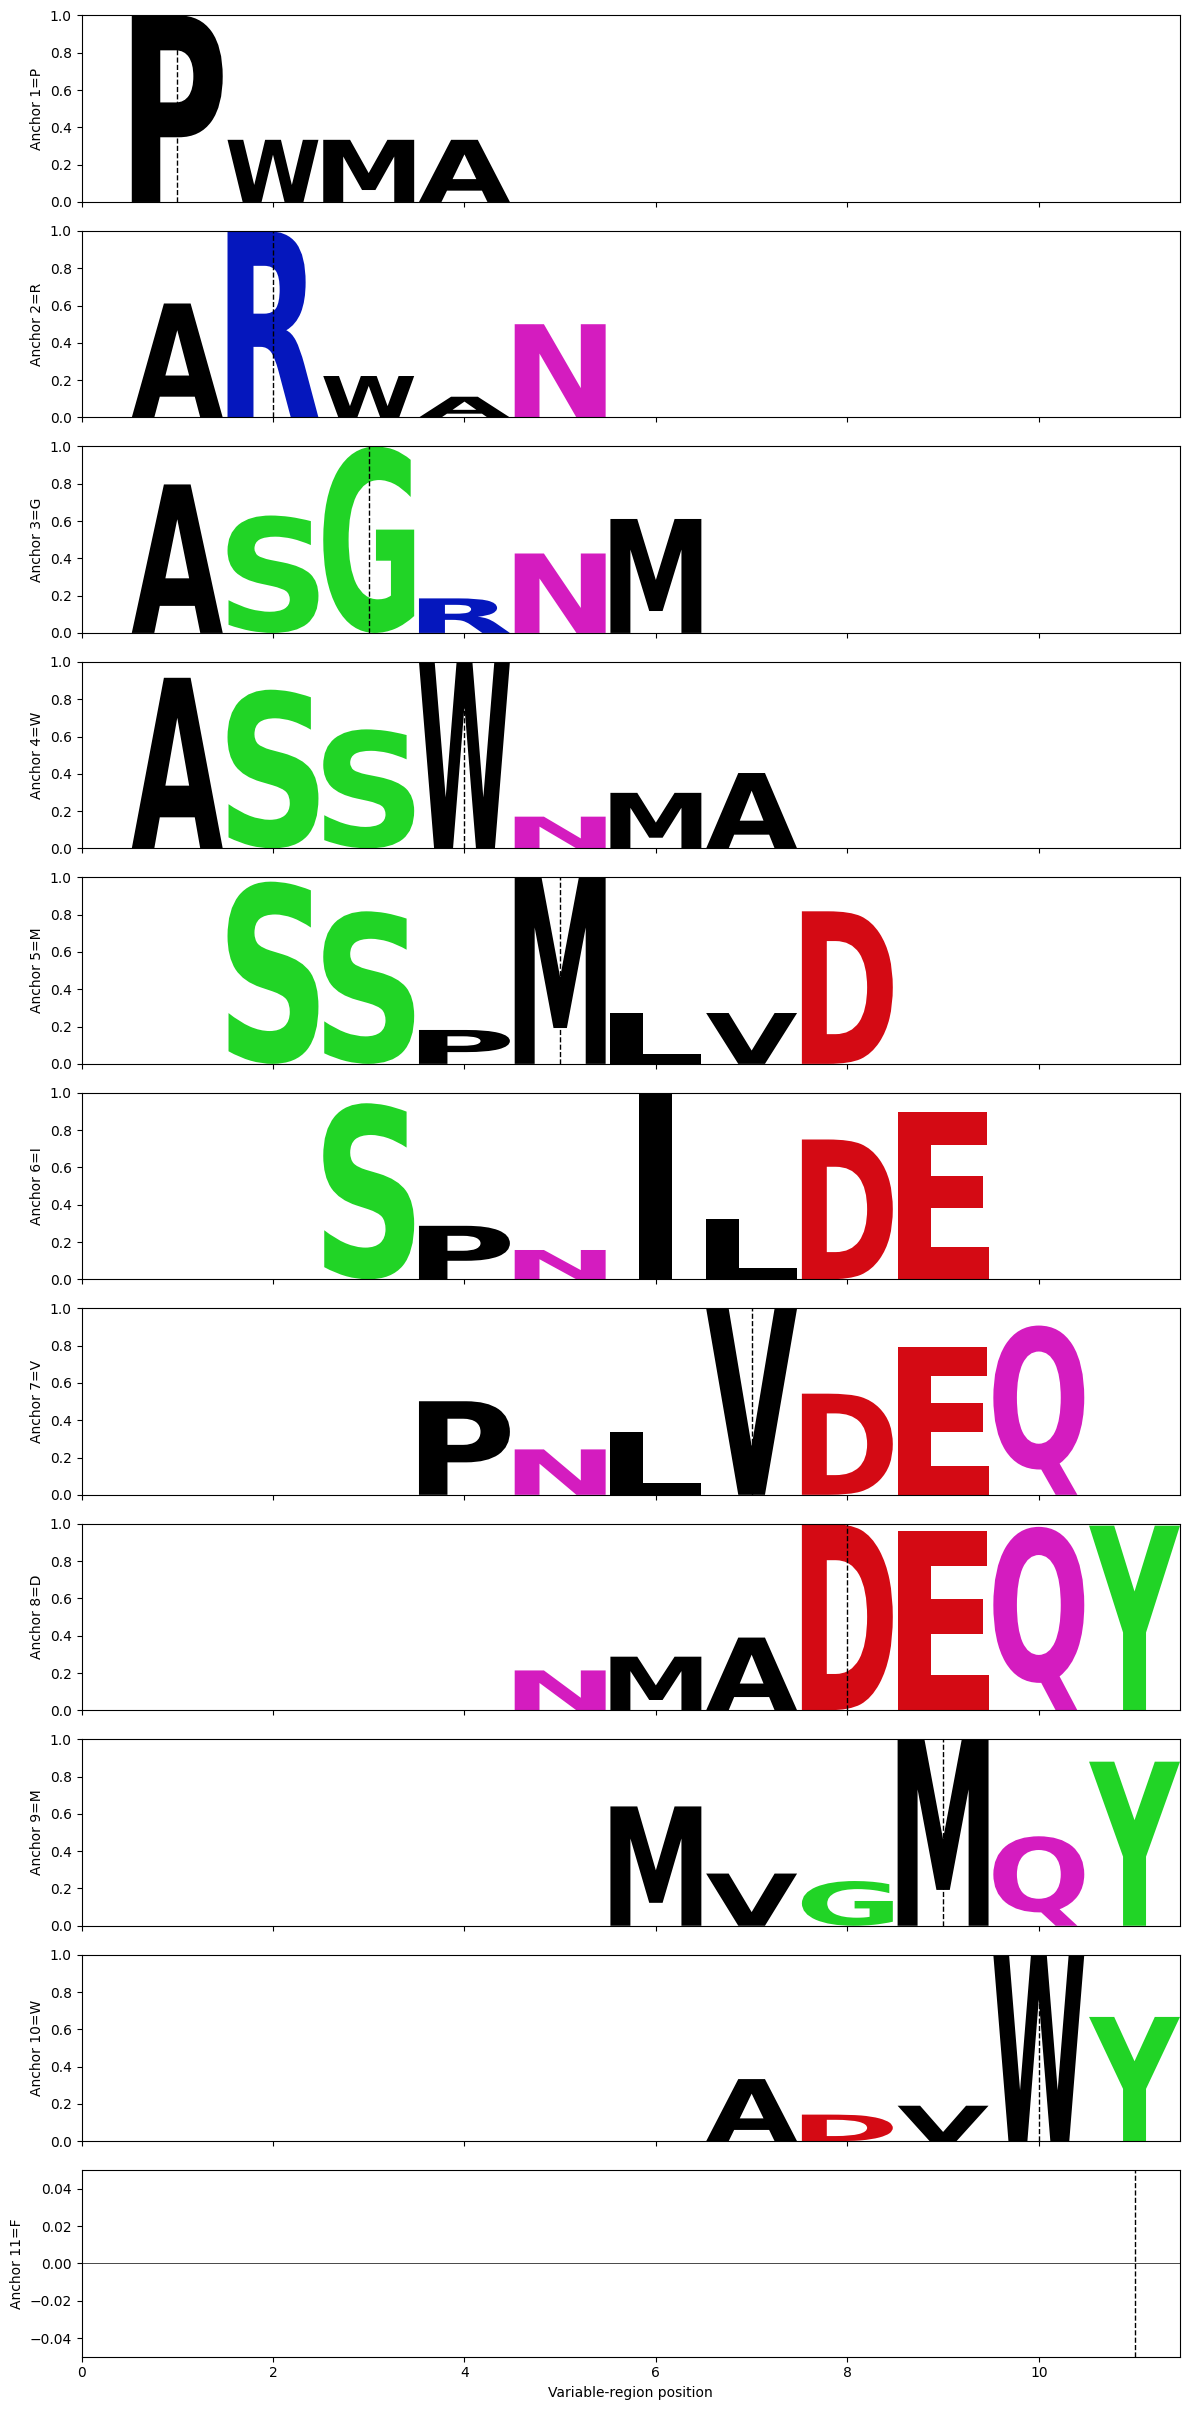

In [121]:
# --- Plot stacked aligned logos ---
n_anchors = SEQ_LEN
fig, axes = plt.subplots(n_anchors, 1, figsize=(12, 2.2 * n_anchors), sharex=True)

if n_anchors == 1:
    axes = [axes]

for pos in range(SEQ_LEN):
    anchor_aa = top_anchor[pos]
    logo_df, positions = tile_matrix_top_cooccurring(df_pos, pos, anchor_aa)
    ax = axes[pos]

    logomaker.Logo(
        logo_df,
        ax=ax,
        fade_below=0.0,
        shade_below=0,
        stack_order="big_on_top"
    )

    # anchor line
    ax.axvline(x=pos+1, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(f"Anchor {pos+1}={anchor_aa}")

axes[-1].set_xlabel("Variable-region position")
plt.tight_layout()
plt.show()

Top anchor residue: S at position 1


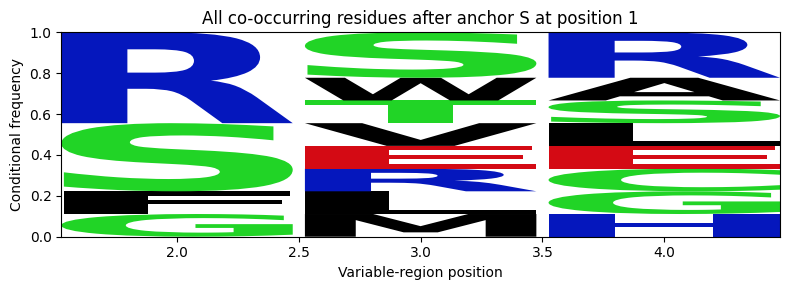

In [129]:
# -----------------------------
# Configuration
# -----------------------------
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")  # standard amino acids
NUM_FOLLOWING_POS = 3                  # number of positions after anchor to show
LOGO_HEIGHT_CLIP = 3                   # optional: clip log-odds if needed

# -----------------------------
# Prepare data
# -----------------------------
# df['cdr3'] should already exist and have sequences like "CASSPNMADEQYF"
# df['specificity'] = 0 (unspecific) or 1 (specific)
df["cdr3_var"] = df["cdr3"].str[1:12]  # remove leading C and trailing F
SEQ_LEN = len(df["cdr3_var"].iloc[0]) 
df_pos = df[df["specificity"] == 1]    # positive/specific sequences

# -----------------------------
# Find top anchor residue and position
# -----------------------------
# Count frequency of each AA across all positions in positives
anchor_counts = df_pos["cdr3_var"].apply(lambda s: pd.Series(list(s))).stack().value_counts()
top_anchor_aa = anchor_counts.idxmax()

# Find the first position in the variable region where this AA occurs
top_anchor_pos = None
for pos in range(SEQ_LEN):
    if (df_pos["cdr3_var"].str[pos] == top_anchor_aa).any():
        top_anchor_pos = pos
        break

if top_anchor_pos is None:
    raise ValueError("Top anchor amino acid not found in any positive sequence!")

print(f"Top anchor residue: {top_anchor_aa} at position {top_anchor_pos+1}")

# -----------------------------
# Function: co-occurrence frequencies
# -----------------------------
def cooccurrence_all(df_pos, anchor_pos, anchor_aa, num_following=NUM_FOLLOWING_POS):
    """Return conditional frequencies of all amino acids at positions following the anchor."""
    # positions after the anchor
    positions = [anchor_pos + i for i in range(1, num_following+1) if anchor_pos + i < SEQ_LEN]

    # subset positive sequences with anchor
    subset = df_pos[df_pos["cdr3_var"].str[anchor_pos] == anchor_aa]

    if len(subset) == 0:
        print("No sequences found for this anchor!")
        return pd.DataFrame(), positions

    # count occurrences
    counts = pd.DataFrame(0.0, index=positions, columns=AA_LIST)
    for pos in positions:
        for aa in AA_LIST:
            counts.loc[pos, aa] = (subset["cdr3_var"].str[pos] == aa).sum()

    # conditional frequencies
    freqs = counts.div(counts.sum(axis=1), axis=0).fillna(0)

    # absolute positions for plotting
    freqs.index = [p + 1 for p in positions]

    return freqs, positions

# -----------------------------
# Generate logo
# -----------------------------
logo_df, positions = cooccurrence_all(df_pos, top_anchor_pos, top_anchor_aa, NUM_FOLLOWING_POS)

if logo_df.empty:
    print("Nothing to plot: the anchor residue has no sequences.")
else:
    fig, ax = plt.subplots(figsize=(8, 3))
    logomaker.Logo(
        logo_df,
        ax=ax,
        fade_below=0.0,
        shade_below=0,
        stack_order="big_on_top"
    )
    # mark anchor
    ax.axvline(x=top_anchor_pos+1, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Variable-region position")
    ax.set_ylabel("Conditional frequency")
    ax.set_title(f"All co-occurring residues after anchor {top_anchor_aa} at position {top_anchor_pos+1}")
    plt.tight_layout()
    plt.show()

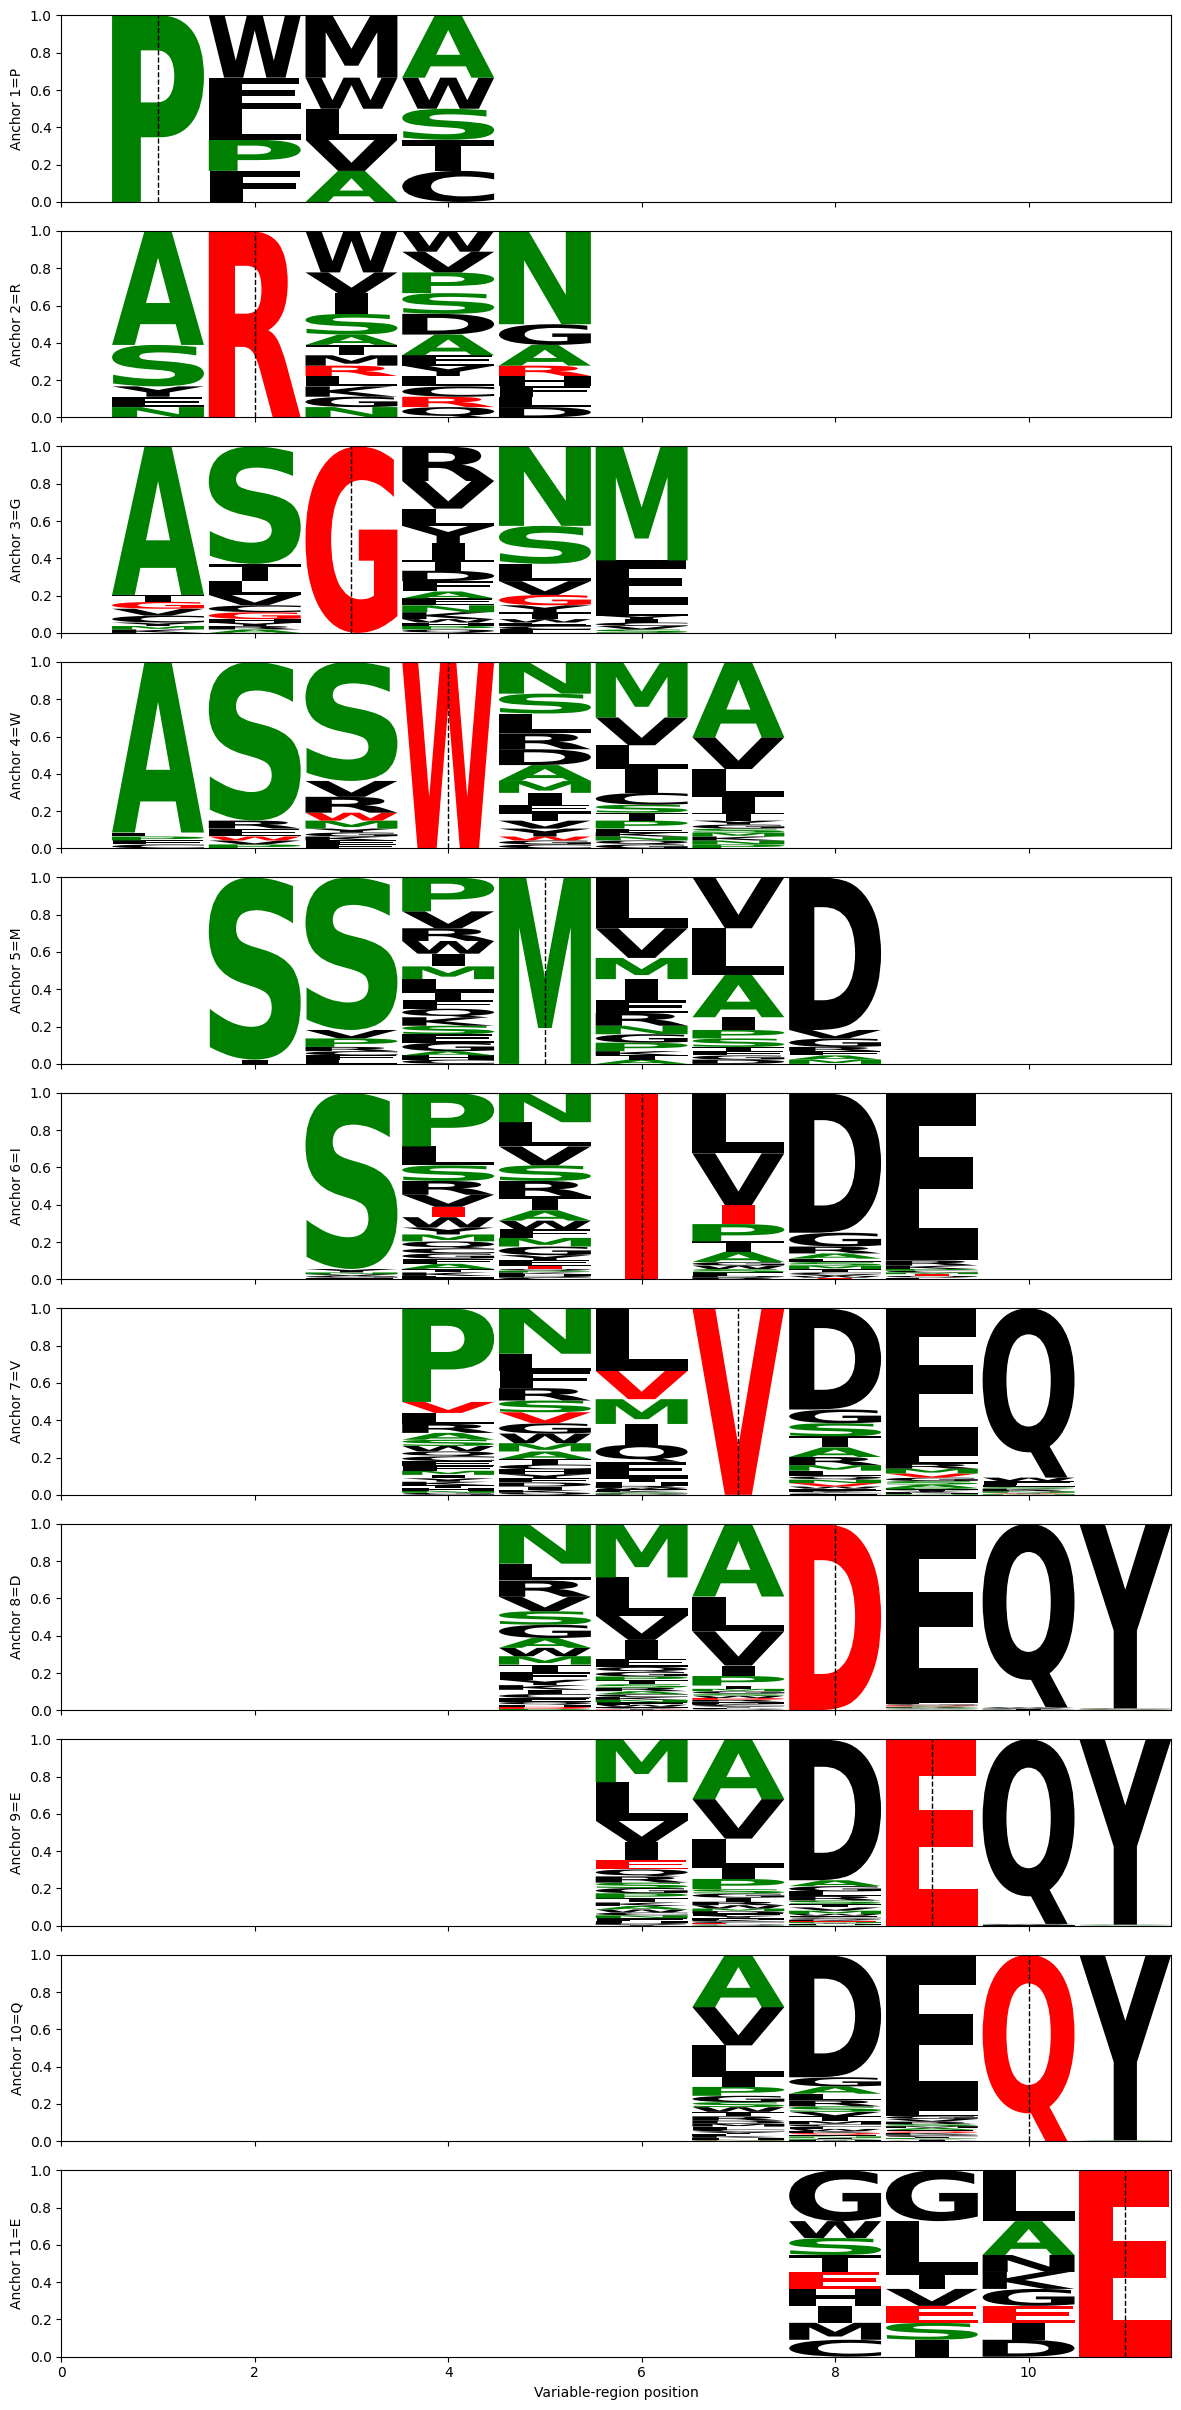

In [7]:
# Amino acids
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")

# Remove leading C and trailing F
df["cdr3_var"] = df["cdr3"].str[1:12]  
SEQ_LEN = len(df["cdr3_var"].iloc[0]) 
df_pos = df[df["specificity"] == 1]

# Wild-type sequence (adjust length to match df["cdr3_var"])
wt_seq = "ASSPNMADEQY"

# --- Step 1: Find top enriched anchor residues per position ---
top_anchor = {}
for pos in range(SEQ_LEN):
    scores = {}
    for aa in AA_LIST:
        pos_pos = ((df["cdr3_var"].str[pos] == aa) & (df["specificity"] == 1)).sum()
        pos_neg = ((df["cdr3_var"].str[pos] == aa) & (df["specificity"] == 0)).sum()
        scores[aa] = np.log((pos_pos + 0.0001) / (pos_neg + 0.0001))
    top_anchor[pos] = max(scores, key=scores.get)

# --- Step 2: Build frequency matrix for a tile around anchor ---
def tile_matrix_freq(df_pos, anchor_pos, anchor_aa):
    start = max(0, anchor_pos - 3)
    end = min(SEQ_LEN - 1, anchor_pos + 3)
    positions = list(range(start, end + 1))

    subset = df_pos[df_pos["cdr3_var"].str[anchor_pos] == anchor_aa]

    counts = pd.DataFrame(0.0, index=positions, columns=AA_LIST)
    for pos in positions:
        for aa in AA_LIST:
            counts.loc[pos, aa] = (subset["cdr3_var"].str[pos] == aa).sum()

    # Frequencies
    freqs = counts.div(counts.sum(axis=1), axis=0).fillna(0)

    # Absolute positions
    freqs.index = [p + 1 for p in positions]

    return freqs, positions

# --- Step 3: Color dictionary for logomaker ---
def make_color_dict(freqs, anchor_pos, anchor_aa, wt_seq):
    color_dict = {}
    for aa in freqs.columns:
        # Default: black
        color_dict[aa] = "black"
    # Highlight anchor in red
    anchor_abs_pos = anchor_pos + 1
    if anchor_abs_pos in freqs.index:
        color_dict[anchor_aa] = "red"
    # Highlight WT residues in green
    for idx, pos in enumerate(freqs.index):
        if idx < len(wt_seq):
            wt_aa = wt_seq[idx]
            color_dict[wt_aa] = "green"
    return color_dict

# --- Step 4: Plot stacked aligned logos ---
n_anchors = SEQ_LEN
fig, axes = plt.subplots(n_anchors, 1, figsize=(12, 2.2 * n_anchors), sharex=True)

if n_anchors == 1:
    axes = [axes]

for pos in range(SEQ_LEN):
    anchor_aa = top_anchor[pos]
    logo_df, positions = tile_matrix_freq(df_pos, pos, anchor_aa)
    ax = axes[pos]

    color_dict = make_color_dict(logo_df, pos, anchor_aa, wt_seq)

    logomaker.Logo(
        logo_df,
        ax=ax,
        fade_below=0.0,
        shade_below=0,
        stack_order="big_on_top",
        color_scheme=color_dict
    )

    # Anchor vertical line
    ax.axvline(x=pos + 1, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(f"Anchor {pos+1}={anchor_aa}")

axes[-1].set_xlabel("Variable-region position")
plt.tight_layout()
plt.show()


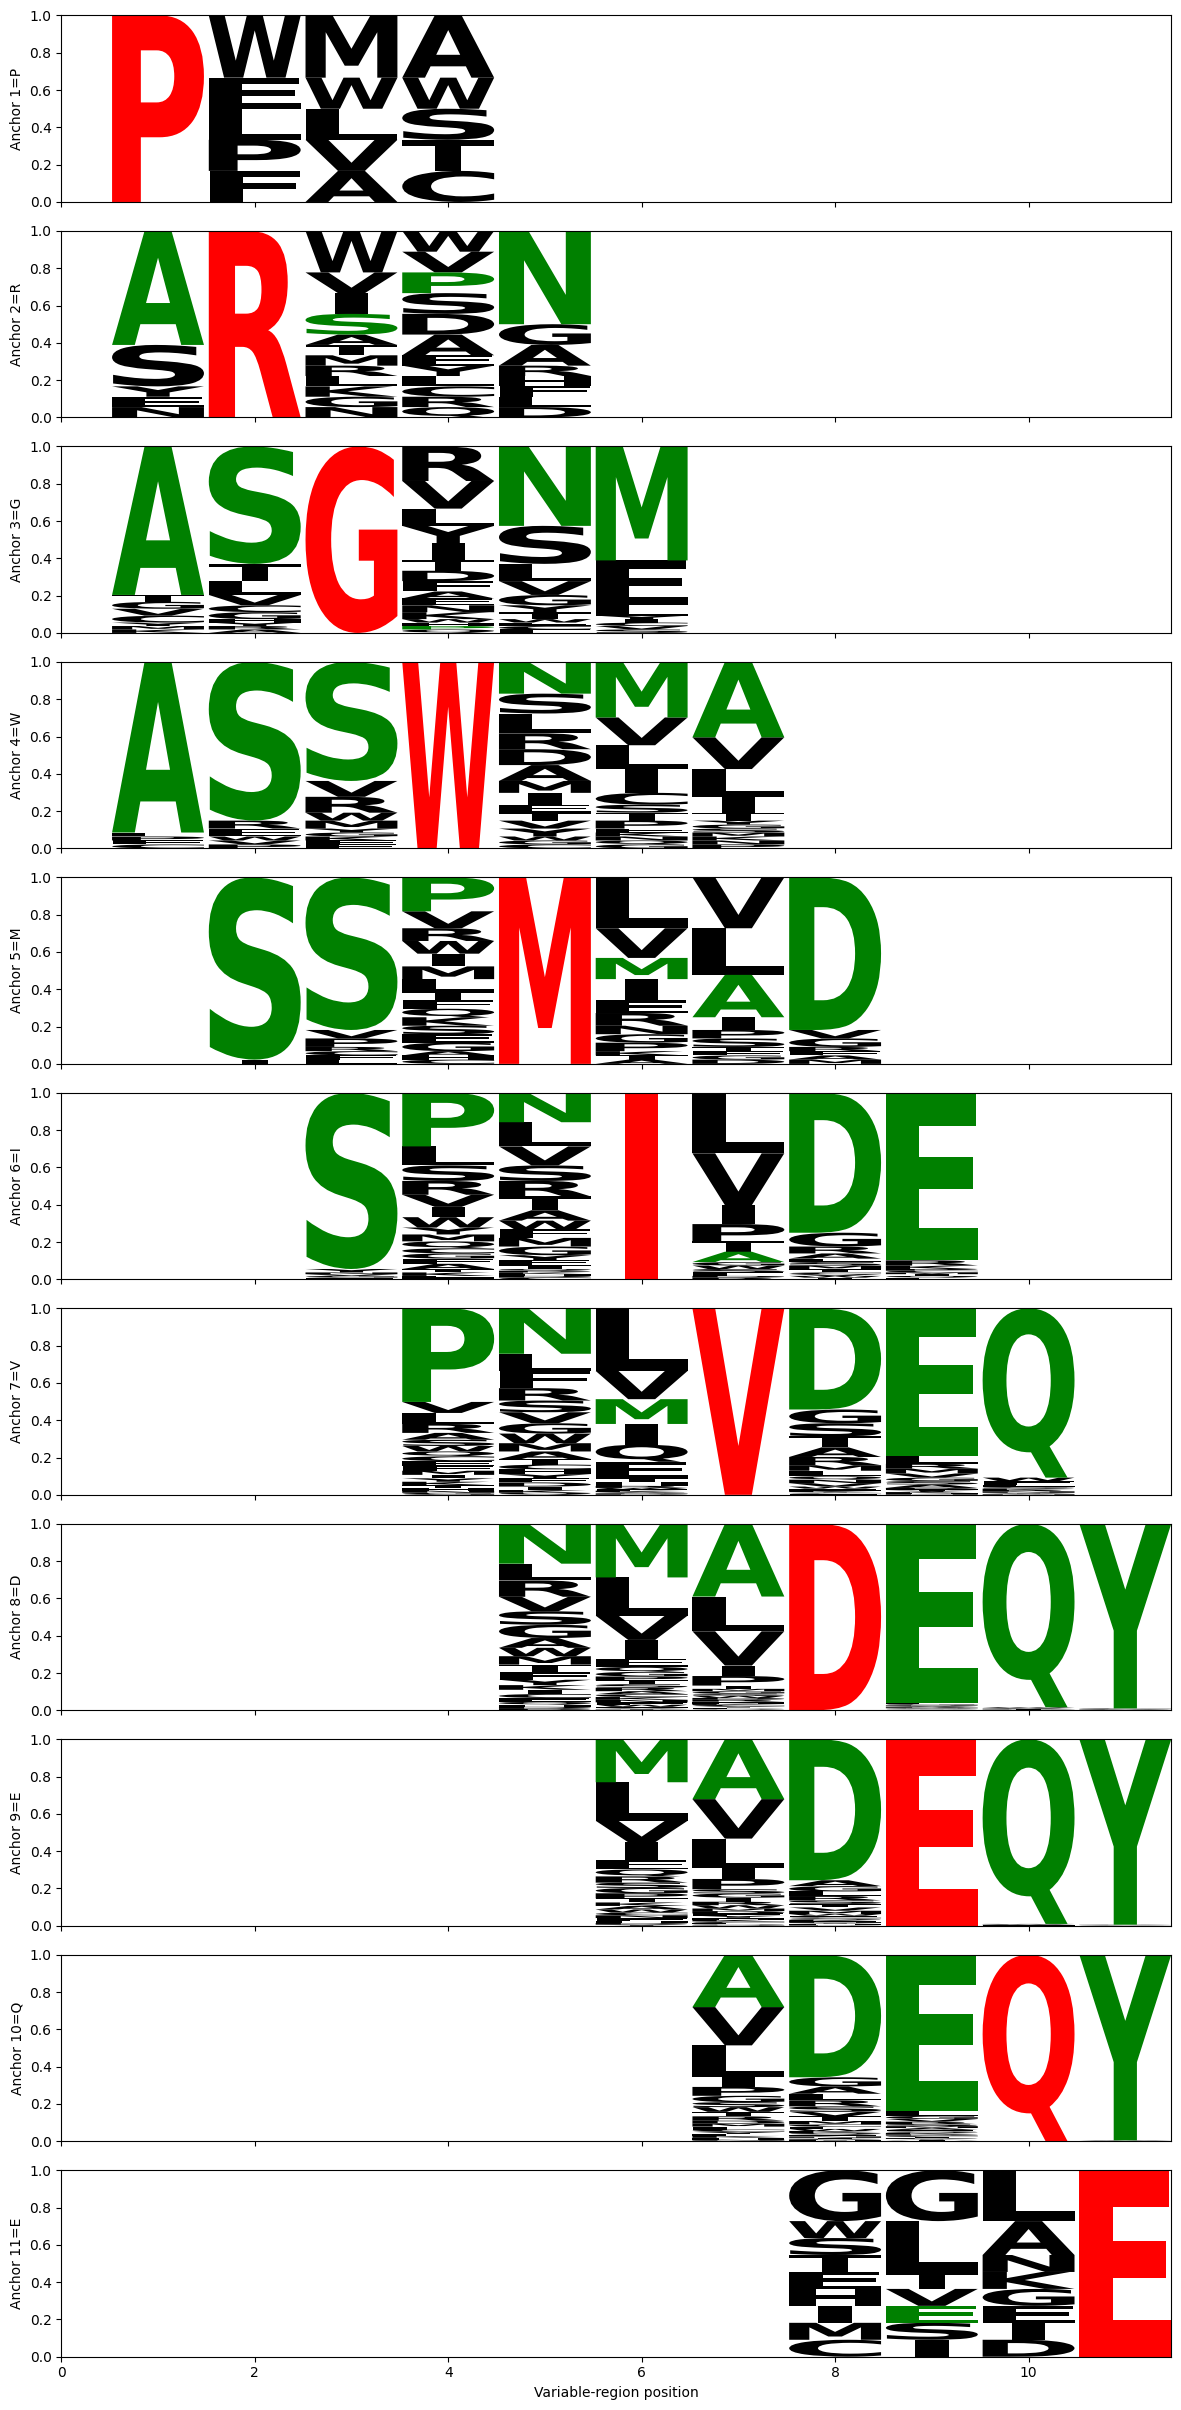

In [11]:
import logomaker
import matplotlib.pyplot as plt

# --- Step 4: Plot stacked aligned logos using style_single_glyph ---
fig, axes = plt.subplots(SEQ_LEN, 1, figsize=(12, 2.2 * SEQ_LEN), sharex=True)
if SEQ_LEN == 1:
    axes = [axes]

for anchor_pos in range(SEQ_LEN):
    anchor_aa = top_anchor[anchor_pos]

    logo_df, tile_positions = tile_matrix_freq(df_pos, anchor_pos, anchor_aa)
    ax = axes[anchor_pos]

    # Create logo (everything black by default)
    logo = logomaker.Logo(
        logo_df,
        ax=ax,
        fade_below=0.0,
        shade_below=0,
        stack_order="big_on_top",
        color_scheme="black"
    )

    # --- Position-specific coloring ---
    for abs_pos in logo_df.index:
    # WT coloring (green) at its true absolute position
        wt_aa = wt_seq[abs_pos - 1]
        logo.style_single_glyph(
            p=abs_pos,
            c=wt_aa,
            color="green"
        )

        # Anchor coloring (red) ONLY at anchor position
        if abs_pos == anchor_pos + 1:
            logo.style_single_glyph(
                p=abs_pos,
                c=anchor_aa,
                color="red"
            )

    # Anchor vertical line
    #anchor_col = tile_positions.index(anchor_pos) if anchor_pos in tile_positions else None
    #if anchor_col is not None:
    #    ax.axvline(x=anchor_col + 0.5, color="black", linestyle="--", linewidth=1)

    ax.set_ylabel(f"Anchor {anchor_pos+1}={anchor_aa}")

axes[-1].set_xlabel("Variable-region position")
plt.tight_layout()
plt.show()